In [1]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
headlines = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',
                         lines = True)

In [3]:
headlines.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

Let's just make sure that the observations corresponding to the two labels (**is_sarcastic = 0, 1** are balanced. We see that there are 14,985 of headlines that have been identified as not sarcastic and 13,634 of headlines that have been identified as sarcastic. We are going to keep these observations as they are. 

In [4]:
headlines.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

## Split Data into Train and Validation Data

In [5]:
train_df, val_df = np.split(headlines.sample(frac = 1), [int(0.8 * len(headlines))])

In [6]:
print("Number of observations in training data set: {}".format(len(train_df)))
print("Number of observations in validation data set: {}".format(len(val_df)))

Number of observations in training data set: 22895
Number of observations in validation data set: 5724


In [13]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.headline, train_df.is_sarcastic)).shuffle(len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.headline, val_df.is_sarcastic)).shuffle(len(val_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## BERT-based Classifier

Here, we are going to use a BERT model that has been pre-trained on English Wikipedia and BooksCorpus datasets. To start things off, we are going to use the **wiki_books** model. In subsequent iterations, we are going to use models that have been fine-tuned for other purposes such as sentiment analysis ... etc. Find out more about the models [here](https://tfhub.dev/google/collections/experts/bert/1).

In [9]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2"
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [10]:
preprocess_layer = hub.KerasLayer(PREPROCESS_MODEL)
bert_layer = hub.KerasLayer(BERT_MODEL)

In [17]:
input_layer = tf.keras.Input(shape = (), dtype = tf.string)
encoder_input = preprocess_layer(input_layer)
encoder_output = bert_layer(encoder_input)

output = tf.keras.layers.Dropout(0.3)(encoder_output['pooled_output'])
output = tf.keras.layers.Dense(64, activation = 'relu')(output)
output = tf.keras.layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)

model = tf.keras.Model(inputs = [input_layer], outputs = output)
model.compile(optimizer = tf.keras.optimizers.AdamW(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [19]:
history = model.fit(train_dataset, 
                    validation_data = val_dataset,
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5979
Epoch 1: val_loss improved from inf to 0.58538, saving model to model/best_performed_model.ckpt
90/90 [==============================] - 528s 6s/step - loss: 0.6719 - accuracy: 0.5979 - val_loss: 0.5854 - val_accuracy: 0.6974
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.6027 - accuracy: 0.6762
Epoch 2: val_loss improved from 0.58538 to 0.53922, saving model to model/best_performed_model.ckpt
90/90 [==============================] - 523s 6s/step - loss: 0.6027 - accuracy: 0.6762 - val_loss: 0.5392 - val_accuracy: 0.7353
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7040
Epoch 3: val_loss improved from 0.53922 to 0.52954, saving model to model/best_performed_model.ckpt
90/90 [==============================] - 523s 6s/step - loss: 0.5715 - accuracy: 0.7040 - val_loss: 0.5295 - val_accuracy: 0.7248
Epoch 4/30
90/90 [==============

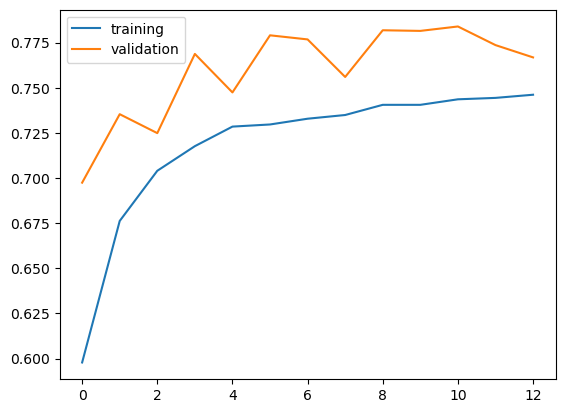

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

I find it odd how validation accuracy continues to be higher than training accuracy for all 13 epochs. The model stopped training after 13 epochs and achieved a validation accuracy of 0.78. This is not a terrible performance compared to the other models that have been trained for the purpose of detecting sarcasm in this news article headline data set. 

## Test the Model

Let's load the model and test it out to see if it can correctly classify some headlines. As sarcasm is not one of my strong suits, we are going to ask ChatGPT to write a few headlines. I used the Default (GPT-3.5) model using ChatGPT platground and gave the prompt, "Write me a sarcastic headline." Here are the two sarcastic headlines that I used:

1. "Brilliant Idea: World Leaders Gather to Solve All Global Problems Over a Cup of Tea
2. "Oh Joy! Another Exciting Day of Endless Emails and Pointless Meetings Awaits at the Office!"

In [33]:
model.predict(["Brilliant Idea: World Leaders Gather to Solve All Global Problems Over a Cup of Tea!",
               "Oh Joy! Another Exciting Day of Endless Emails and Pointless Meetings Awaits at the Office!"])

1/1 [==============================] - 0s 48ms/step


array([[0.5397034 ],
       [0.47371277]], dtype=float32)

The first headline was classified as sarcastic (>0.50), but the second headline was not classified as sarcastic (<0.50). That's unfortunate. Let's test out two non-sarcastic headlines. Here are the two non-sarcastic headlines that I used. The expectation is that the two headlines would be classified as **not sarcastic**:

1. "New Study Reveals Promising Breakthrough in Cancer Research"
2. "Tech Company Unveils Revolutionary Device Set to Transform Everyday Living"

In [34]:
model.predict(["New Study Reveals Promising Breakthrough in Cancer Research",
               "Tech Company Unveils Revolutionary Device Set to Transform Everyday Living"])

1/1 [==============================] - 0s 48ms/step


array([[0.1679425 ],
       [0.53634316]], dtype=float32)

The first headline was classified as not sarcastic (<0.50), but the second headline was classified as sarcatic (>0.50). The model needs to do better. 